In [4]:
import numpy as np
import seaborn as sns
import simpy
import random
import statistics


In [18]:
wait_times = []
total_floors = 8
lobby_floor = 0


In [34]:
class Hotel(object):
    def __init__(self, env, num_lifts):
        self.env = env
        self.lift = simpy.Resource(env, num_lifts)
    def go_to_room(self, guest, guest_floor, room_floor):
        yield self.env.timeout((guest_floor-room_floor) ** 2/total_floors)
    def go_to_lobby(self, guest, guest_floor):
        yield self.env.timeout((guest_floor ** 2) / total_floors)
        

In [35]:
def call_lift(env, guest, Hotel):
    # guest calls a lift
    arrival_time = env.now
    room_floor = random.randint(1, total_floors)
    guest_floor = random.choice([room_floor, lobby_floor])
    
    if guest_floor == room_floor:
        with Hotel.lift.request() as request:
            yield request
            yield env.process(Hotel.go_to_lobby(guest, room_floor))
            wait_times.append(env.now - arrival_time)
    
    else: 
        with Hotel.lift.request() as request:
            yield request
            yield env.process(Hotel.go_to_room(guest, guest_floor, room_floor))
            wait_times.append(env.now - arrival_time)
            

In [36]:
def run_hotel(env, num_lifts):
    hotel = Hotel(env, num_lifts)

    for guest in range(3):
        env.process(call_lift(env, guest, hotel))

    while True:
        yield env.timeout(0.20)  # Wait a bit before generating a new person

        guest += 1
        env.process(call_lift(env, guest, hotel))


Average wait time: 5.09 units


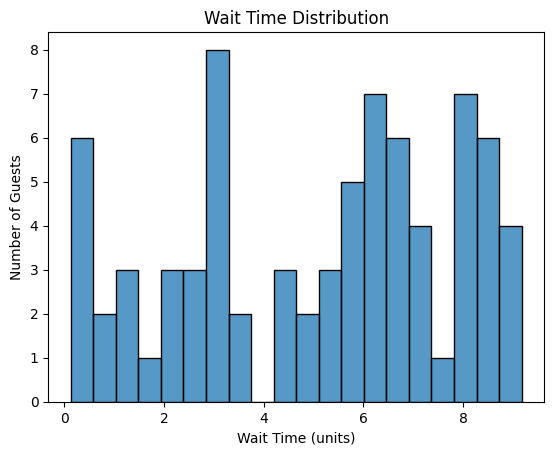

In [46]:
#run_hotel(simpy.Environment(), num_lifts=2)
env = simpy.Environment()
env.process(run_hotel(env, num_lifts=2))
env.run(until=10)
# Calculate average wait time
average_wait_time = statistics.mean(wait_times)
# Print the average wait time
print(f"Average wait time: {average_wait_time:.2f} units")
# Plot the wait times
sns.histplot(wait_times, bins=20)
import matplotlib.pyplot as plt
plt.xlabel('Wait Time (units)')
plt.ylabel('Number of Guests')
plt.title('Wait Time Distribution')
plt.show()
